# 4b. Classification Task: Using Machine Learning to Predict Retraction

## Introduction


This Notebook performs our **main classification task**. It uses some of the most common classifier models (**logistic regressor, XGBoost Classifier, and Random Forest Classifier**) to predict what papers are at risk of retraction, and the most common vectorizers (**Bag of Words and tf-idf**) to convert text data into numbers that our models can process. 

The Notebook uses the corpus of abstracts that was generated in **Notebook 4a**. The trained models that the Notebook produces will in turn serve as input for **Notebook 4c**, in which we will test whether the models possess a bias as far as the year and country of publication of the papers in our corpus are concerned.

The **workflow** of the notebook is set up as follows:

- Input: **one .csv file** with our corpus with text from both retracted and non-retracted papers.
- Output: **none** with our three traine models.

## Input / Output Parameters

Input parameters:

In [106]:

# File path to corpus to train model

input_path = "../data/final_corpus.csv"

# Number of top features with the most relevance for classificatio task to be displayed in our analysis

k_value = 20


Output parameters:

In [107]:

# File path to trained logistic regressor

output_path_log_reg = "../data/trained_models/logistic_regressor.pkl"

# File path to trained xgboost classifier

output_path_xgboost = "../data/trained_models/xgboost_classifier.pkl"

# File path to trained random forest classifier

output_path_rf = "../data/trained_models/random_forest_classifier.pkl"

# File path to word count vectorizer

output_path_vectorizer = "../data/trained_models/vectorizer.pkl"

# File path to tf-idf vectorizer

output_path_tfidf = "../data/trained_models/tfidf.pkl"




## Importing Required Libraries

Let us start by importing the required libraries to implement our task:

In [108]:

# Import required libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import joblib

from scipy.stats import norm

import time
from function_definitions import seconds_to_hms


## Data Preprocessing and Test-Train Split


Let us start by loading the textual corpus that we will use to train our models into our data frame:

In [109]:

# Create data frame with all abstracts

df_corpus = pd.read_csv(input_path, encoding='latin-1')

# Visualize data frame for verification

df_corpus


,abstract_text,target,doi,country,year,ret_flag
0,"""Atrial fibrosis occurs frequently with struct...",1,10.1038_s41420-022-00895-9,CN,2022,False
1,"""In Brief Purpose To determine the safety and ...",1,10.1097_00006982-200402000-00018,US,2004,False
2,"""Biglycan (BGN) is an important component of t...",0,10.1016_j.molonc.2016.08.002,CN,2016,False
3,"""Fusarium wilt caused by Fusarium oxysporum f....",0,10.3390_toxins12040254,CN,2020,False
4,"""The genome of Stenotrophomonas maltophilia en...",1,10.1128_JB.00310-07,IE,2007,False
...,...,...,...,...,...,...
13052,"""Globally the incidence and mortality rates o...",0,10.1186_s12885-019-5810-2,CN,2019,False
13053,"""Background: Apigenin is known to have a broad...",1,10.2147_IJN.S256494,CN,2020,False
13054,"""Endophytic fungi act as seed endosymbiont th...",0,10.3389_fmicb.2022.814864,CN,2022,False
13055,"""Severe acute respiratory syndrome coronavirus...",0,10.1128_jvi.00011-23,CN,2023,False


We can now define the target and features that we will use for our classification task:

In [110]:

# Definte target and features

X = df_corpus["abstract_text"]
y = df_corpus["target"]


And split our data set into train and test portions:

In [111]:

# Split target and features into train and text sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Bag of Words Vectorization


In order to be able to train our classifiers, we will need a method to translate our corpus, which is made out of text, into numbers. We will need, in other words, a vectorization process that turns words into vectors with numerical components. We will first try the most simple vectorization method, namely the "bag of words" method, to accomplish this. First we need to translate the train portion of our corpus into a set of vectors:


In [112]:

# Instantiate CountVectorizer 

vectorizer = CountVectorizer()

# Fit vectorizer to corpus of fraudulent papers to create bag of words vectors

X_train_vec = vectorizer.fit_transform(X_train)

# Obtain vocabulary for corpus

print("Bag of Words Vocabulary:\n")
print(vectorizer.get_feature_names_out())

# Print all bag of words vectors 

print("\nBag of Words Vectors:\n")
print(X_train_vec.toarray())
print("\n")


Bag of Words Vocabulary:

['00' '000' '0000' ... 'zyxin' 'zyxincdk8yap' 'zz']

Bag of Words Vectors:

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]




Now we can use the correspondence between words and vectors that we have just generated to vectorize the test porition of our corpus:

In [113]:

# Vectorize test data set by using our vectorizer

X_test_vec = vectorizer.transform(X_test)

# Visualize vectorized features for confirmation

print("\nVectorized features (BoW):\n")
print(X_test_vec.toarray())
print("\n")



Vectorized features (BoW):

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]




## TF-IDF Vectorization


We can also try a slightly more sophisticated vectorization method called tf-idf. Again, we first apply the vectorizer to the train portion of our corpus:


In [114]:

# Instantiate CountVectorizer 

tfidf = TfidfVectorizer()

# Fit vectorizer to corpus of fraudulent papers to create vectors

X_train_tfidf = tfidf.fit_transform(X_train)

# Obtain vocabulary for corpus

print("\nTF-IDF Vocabulary:\n")
print(tfidf.get_feature_names_out())

# Print all vectors 

print("\nTF-IDF vectors:\n")
print(X_train_tfidf.toarray())
print("\n")




TF-IDF Vocabulary:

['00' '000' '0000' ... 'zyxin' 'zyxincdk8yap' 'zz']

TF-IDF vectors:

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]





And we then use the vocabulary generated from the train data set to vectorize out test data set:


In [115]:

# Vectorize test data set using vocabulary from train

X_test_tfidf = tfidf.transform(X_test)

# Visualize vectorized features for confirmation

print("\nVectorized features (TF-IDF):\n")
print(X_test_vec.toarray())
print("\n")



Vectorized features (TF-IDF):

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]




## K-Best Analysis 


Now that we have vectorized our corpus, and before we use it to train our models, we can run a K-Best analysis on our data set. This will give us an idea of which ones of our features (in our case, vectors corresponding to a word in our corpus) are more strongly correlated with the different values that our target can get. A K-best analysis will give us a sense, in other words, of which words are more strongly correlated (either positively or negatively) with retraction:


In [116]:

# Instantiate K-Best Selector

k_best = SelectKBest(score_func=f_classif, k = k_value)  

# Fit K-Best Selector to training data 

X_train_selected_vec = k_best.fit_transform(X_train_vec, y_train)

# Get indices of k most salient features

selected_feature_indices = k_best.get_support(indices=True)

# Obtain words corresponding to each index from vectorizer

features_list = vectorizer.get_feature_names_out()

# Obtain words corresponding to most salient features from index

selected_feature_names = [features_list[i] for i in selected_feature_indices]

# Visualize most salient words

selected_feature_names

# Obtain scores of selected features

selected_feature_scores = k_best.scores_[selected_feature_indices]

# Pair feature names with their corresponding scores

feature_scores = list(zip(selected_feature_names, selected_feature_scores))

# Print feature names and scores

max_width = max(len(feature) for feature, _ in feature_scores)

print(f"\nTop {k_value} Features with Greatest Correlation to Retraction are:\n")

for feature_name, score in feature_scores:
    print(f"Word: {feature_name.ljust(max_width)}  Score: {round(score, 2):>8}")

print("\n")



Top 20 Features with Greatest Correlation to Retraction are:

Word: apoptosis      Score:    256.5
Word: assay          Score:   505.94
Word: blot           Score:   315.98
Word: conclusion     Score:   318.86
Word: cytometry      Score:   316.73
Word: effects        Score:    270.6
Word: endoplasmic    Score:    274.9
Word: expression     Score:   579.91
Word: inhibited      Score:   274.02
Word: invasion       Score:   436.22
Word: luciferase     Score:   354.02
Word: mir            Score:    820.8
Word: proliferation  Score:   394.96
Word: reticulum      Score:    260.7
Word: species        Score:   308.49
Word: target         Score:   321.38
Word: tissues        Score:   389.83
Word: transwell      Score:   317.89
Word: was            Score:   332.81
Word: western        Score:   367.92





It will be instructive to choose the most predictive word in our corpus and see what are the abstracts in our corpus that include it:


In [117]:

# Create filtered data frame with abstracts that include the word "assay" only

df_key_word = df_corpus[df_corpus["abstract_text"].str.contains("assay")]

# Visualize abstracts in filtered data frame

df_key_word["abstract_text"]


3        "Fusarium wilt caused by Fusarium oxysporum f....
5        "Cerebellar fastigial nucleus electrical stimu...
6        "Retinoblastoma is an ocular malignancy occurr...
9        "MicroRNA-145 inhibits the activation of the m...
10       "Involvement of NF-B and HSP70 signaling pathw...
                               ...                        
13036    "Background:Nasopharyngeal carcinoma (NPC) is ...
13045    "Abstract Background Osteosarcoma (OS) is the ...
13047    "Abstract Background Accumulating evidence has...
13051    "Increasing evidence has suggested that microR...
13052    "Globally  the incidence and mortality rates o...
Name: abstract_text, Length: 3209, dtype: object


We can also select one of those abstracts and display its full text for manual inspection:


In [118]:
df_corpus.iloc[5].abstract_text

'"Cerebellar fastigial nucleus electrical stimulation (FNS) in rats has been shown to protect against brain ischemia/reperfusion (I/R) damage. Activation of telomerase has been reported to provide neuroprotection in animal models of stroke.The aim of this study was to explore whether precondition FNS increases the expression of telomerase reverse transcriptase (TERT) and telomerase activity in rats after cerebral I/R injury.One day after continuous stimulation of the fastigial cerebellar nucleus for 1 h  adult male Sprague Dawley rats were subjected to middle cerebral artery occlusion (MCAO) for 2 h and reperfusion for 24 h  48 h and 72 h  while the I/R control groups received the same treatment without FNS. Ischemic lesion volumes were measured following TTC staining. The number of apoptotic cells was measured by using TUNEL assays. Subsequently  telomerase activity was examined by using TRAP-silver staining. Additionally  the expression level of TERT mRNA was assessed by using real-t

Finally, we can also create a word cloud to visualize the extent of each word's correlation with our target, as given by our K-best analysis:

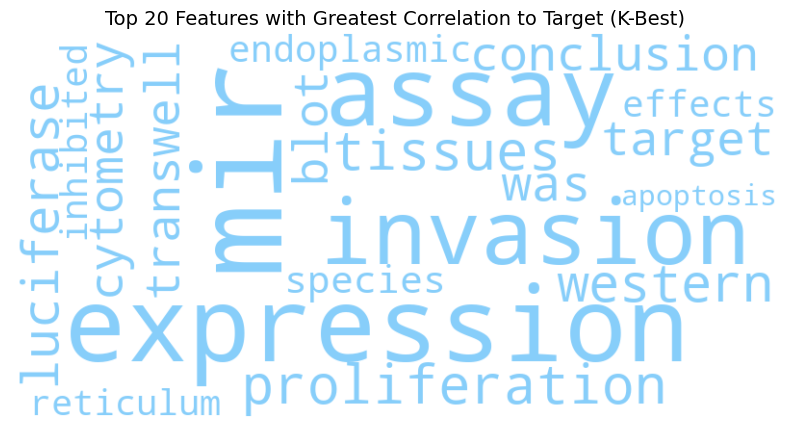

In [119]:


# Separate words with positive and negative coefficients

positive_words = [feature for feature, score in feature_scores if score > 0]
negative_words = [feature for feature, score in feature_scores if score < 0]

# Generate word cloud with custom color function

def fixed_color_func(word, font_size, position, orientation, random_state=42, **kwargs):
    if word in positive_words:
        # Set color to light blue for positive coefficients
        return "rgb(135, 206, 250)"  # Light blue color
    elif word in negative_words:
        # Set color to light grey for negative coefficients
        return "rgb(192, 192, 192)"  # Light grey color
    else:
        # Default color for neutral words
        return "rgb(128, 128, 128)"  # Default grey color

# Convert top_words into a dictionary

word_freq_dict = {feature: abs(score) for feature, score in feature_scores}

# Generate word cloud

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=fixed_color_func)
wordcloud.generate_from_frequencies(word_freq_dict)

# Display the generated word cloud using matplotlib

plt.figure(figsize=(10, 5))
plt.title(f"Top {k_value} Features with Greatest Correlation to Target (K-Best)", fontsize=14)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Classification with Logistic Regression

Since our corpus has been appropriately vectoriyed we can also go on to train various classifiers on it, see how good a job they do at predicting retraction. Let us start with a logistic regressor:

In [120]:

# Instantiate logistic regressor

log_reg = LogisticRegression(max_iter = 200, random_state = 42)

# Store start time of loop execution

start_time = time.time()

# Fit logistic regressor to our train data set

#log_reg.fit(X_train_vec, y_train)

log_reg.fit(X_train_tfidf, y_train)

# Use logistic regressor to obtain predictions for test data set

#y_pred = log_reg.predict(X_test_vec)

y_pred = log_reg.predict(X_test_tfidf)

# And for train data set

#y_pred_train = log_reg.predict(X_train_vec)

y_pred_train = log_reg.predict(X_train_tfidf)

# Calculate elapsed time for for training model

elapsed_time = time.time() - start_time

# Convert time to hours, minutes, and seconds

elapsed_hours, elapsed_minutes, elapsed_seconds = seconds_to_hms(elapsed_time)

# Print message with elapsed time

print(f"The model was successfully trained in : {elapsed_hours}h, {elapsed_minutes}m, {round(elapsed_seconds,3)}s. \n")


The model was successfully trained in : 0.0h, 0.0m, 0.068s. 




We can now see how well our model performs by obtaining some of the usual metrics:

In [121]:

# Obtain accuracy score and other evaluation metrics

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

report_test = classification_report(y_test, y_pred)
report_train = classification_report(y_train, y_pred_train)

# Print scores

print("\nAccuracy on train data set:", accuracy_train)
print("Accuracy on test data set:", round(accuracy_test,2))

print("\nClassification Report for Train (Logistic Regressor):\n\n", report_train)
print("Classification Report for Test (Logistic Regressor):\n\n", report_test)



Accuracy on train data set: 0.9329822881761608
Accuracy on test data set: 0.89

Classification Report for Train (Logistic Regressor):

               precision    recall  f1-score   support

           0       0.94      0.93      0.93      5386
           1       0.93      0.93      0.93      5059

    accuracy                           0.93     10445
   macro avg       0.93      0.93      0.93     10445
weighted avg       0.93      0.93      0.93     10445

Classification Report for Test (Logistic Regressor):

               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1361
           1       0.88      0.88      0.88      1251

    accuracy                           0.89      2612
   macro avg       0.88      0.88      0.88      2612
weighted avg       0.89      0.89      0.89      2612



Let us also obtain the confusion matrix for our classification task:

In [122]:

# Obtain confusion matrix

conf_matrix_log_reg = confusion_matrix(y_test, y_pred)

print("Confusion Matrix for Logistic Regressor:\n\n", conf_matrix_log_reg)


Confusion Matrix for Logistic Regressor:

 [[1212  149]
 [ 151 1100]]



Finally, it will also be useful to obtain the values of the largest coefficients in our trained model, along with the words associated to them. This is because the size of these coefficients can be give us a (sometimes misleading) sense of what features are the most decisive in driving the classification task:

In [123]:

# Obtain coefficients for logistic regressor

coefficients_log_reg = log_reg.coef_[0]
intercept_log_reg = log_reg.intercept_

# Obtain feature names from vocabulary

#feature_names_log_reg = vectorizer.get_feature_names_out()
feature_names_log_reg = tfidf.get_feature_names_out()


# Pair each feature with its coefficient

coefficients_with_features_log_reg = list(zip(feature_names_log_reg, coefficients_log_reg))

# Sort coefficients based on absolute values

sorted_coefficients_log_reg = sorted(coefficients_with_features_log_reg, key=lambda x: abs(x[1]), reverse=True)

# Print the largest coefficients along with their corresponding features (number depends on k_value from k-best analysis)

max_width = max(len(feature) for feature, _ in sorted_coefficients_log_reg[:k_value])

print(f"Top {k_value} Features with Largest Coefficients for Logistic Regressor:\n")
for i, (feature, coefficient) in enumerate(sorted_coefficients_log_reg[:k_value], start=1):
    print(f"{i:>2}. Feature: {feature.ljust(max_width)}  Coefficient: {coefficient:>10.4f}")

Top 20 Features with Largest Coefficients for Logistic Regressor:

 1. Feature: yap          Coefficient:    -6.8115
 2. Feature: mir          Coefficient:     5.2397
 3. Feature: er           Coefficient:    -4.6686
 4. Feature: hippo        Coefficient:    -4.6583
 5. Feature: yap1         Coefficient:    -4.6149
 6. Feature: zebrafish    Coefficient:    -4.3837
 7. Feature: vitiligo     Coefficient:    -4.3462
 8. Feature: stress       Coefficient:    -4.0946
 9. Feature: species      Coefficient:    -3.7143
10. Feature: tyrosinase   Coefficient:    -3.4557
11. Feature: grp78        Coefficient:    -3.4336
12. Feature: endoplasmic  Coefficient:    -3.0627
13. Feature: taurine      Coefficient:    -3.0482
14. Feature: il           Coefficient:     3.0134
15. Feature: reticulum    Coefficient:    -3.0094
16. Feature: calpain      Coefficient:    -2.9978
17. Feature: melanin      Coefficient:    -2.9831
18. Feature: mechanical   Coefficient:    -2.9687
19. Feature: taz          Coeffic

Again, we can create a word cloud for easier visualization, and for comparison with what our K-best analysis gave us: 

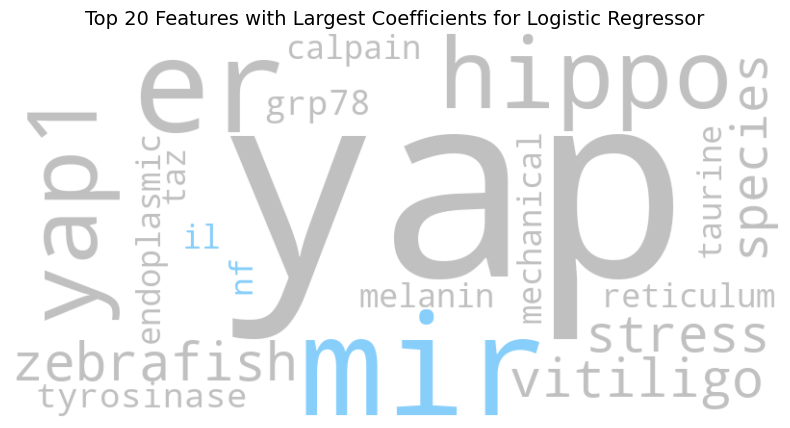

In [124]:

# Select the top words

top_words_log_reg = sorted_coefficients_log_reg[:k_value]

# Separate words with positive and negative coefficients

positive_words = [word for word, coeff in top_words_log_reg if coeff > 0]
negative_words = [word for word, coeff in top_words_log_reg if coeff < 0]

# Generate word cloud with custom color function

def fixed_color_func(word, font_size, position, orientation, random_state=42, **kwargs):
    if word in positive_words:
        # Set color to light blue for positive coefficients
        return "rgb(135, 206, 250)"  # Light blue color
    elif word in negative_words:
        # Set color to light grey for negative coefficients
        return "rgb(192, 192, 192)"  # Light grey color
    else:
        # Default color for neutral words
        return "rgb(128, 128, 128)"  # Default grey color

# Convert top_words into a dictionary

word_freq_dict = {word: abs(coeff) for word, coeff in top_words_log_reg}

# Generate word cloud

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=fixed_color_func)
wordcloud.generate_from_frequencies(word_freq_dict)

# Display the generated word cloud using matplotlib

plt.figure(figsize=(10, 5))
plt.title(f"Top {k_value} Features with Largest Coefficients for Logistic Regressor", fontsize=14)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Classification with XGBoost

It is often be instructive to use different models to perform the same classification task and see which ones fare better than the others. Apart from our logistic regressor, we will also use an XGBoost classifier to classify our papers into retracted and not retracted. We will thus start by instantiating our new model:

In [125]:
xgboost = XGBClassifier(random_state = 42)

We can go ahead and train it on our vectorized train data set:

In [126]:
xgboost.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

With our trained model, we can go on to make predictions for the features in both our test and our train data sets:

In [127]:

# Predictions for the test data set

y_pred_xgb = xgboost.predict(X_test_tfidf)

# And for train data set

y_pred_train_xgb = xgboost.predict(X_train_tfidf)


Having done that, we can obtain some evaluation metrics to see how well our model performs:

In [128]:

# Obtain accuracy score and other evaluation metrics

accuracy_test_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_train_xgb = accuracy_score(y_train, y_pred_train_xgb)

report_test_xgb = classification_report(y_test, y_pred_xgb)
report_train_xgb = classification_report(y_train, y_pred_train_xgb)

# Print scores

print("Accuracy on train data set (XGB Classifier):", accuracy_train_xgb)
print("Accuracy on test data set (XGB Classifier):", round(accuracy_test_xgb,2))

print("\nClassification Report for Train (XGB Classifier):\n\n", report_train_xgb)

print("Classification Report for Test (XGB Classifier):\n\n", report_test_xgb)

Accuracy on train data set (XGB Classifier): 0.9651507898516036
Accuracy on test data set (XGB Classifier): 0.88

Classification Report for Train (XGB Classifier):

               precision    recall  f1-score   support

           0       0.98      0.95      0.97      5386
           1       0.95      0.98      0.96      5059

    accuracy                           0.97     10445
   macro avg       0.97      0.97      0.97     10445
weighted avg       0.97      0.97      0.97     10445

Classification Report for Test (XGB Classifier):

               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1361
           1       0.87      0.89      0.88      1251

    accuracy                           0.88      2612
   macro avg       0.88      0.88      0.88      2612
weighted avg       0.88      0.88      0.88      2612



And we can obtain the confusion matrix for the classification task that our XGBoost classifier performed:

In [129]:

# Obtain confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\nConfusion Matrix for XGB Classifier:\n\n", conf_matrix_xgb)



Confusion Matrix for XGB Classifier:

 [[1194  167]
 [ 140 1111]]


## Classification with Random Forest

We will try a third and last model to classify papers as retracted or non-retracted, namely a random forest classifier. We start by instantiating and traning our model:

In [130]:

# Instantiate and configure the random forest classifier

rf_classifier = RandomForestClassifier(
    n_estimators=2000,
    max_depth=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)


# Start timer to track training time of the model

start_time = time.time()

# Train model

rf_classifier.fit(X_train_tfidf, y_train)

# End timer and display training time

end_time = time.time()
fit_time = end_time - start_time
hours, minutes, seconds = seconds_to_hms(fit_time)
print(f"Training completed in: {hours} hours, {minutes} minutes, and {seconds:.2f} seconds")


Training completed in: 0.0 hours, 0.0 minutes, and 2.58 seconds


With our trained model we can go ahead and obtain the predicted target values for our train and test features:

In [131]:

# Make predictions for test and train data sets

y_pred_rf = rf_classifier.predict(X_test_tfidf)
y_pred_train_rf = rf_classifier.predict(X_train_tfidf)


And obtain some of the usual metrics to evaluate our model's performance:

In [132]:

# Obtain accuracy score and other evaluation metrics

accuracy_test_rf = accuracy_score(y_test, y_pred_rf)
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)

report_test_rf = classification_report(y_test, y_pred_rf)
report_train_rf = classification_report(y_train, y_pred_train_rf)

# Print scores

print("Accuracy on train data set (XGB Classifier):", accuracy_train_rf)
print("Accuracy on test data set (XGB Classifier):", round(accuracy_test_rf,2))

print("\nClassification Report for Train (Random Forest Classifier):\n\n", report_train_rf)

print("Classification Report for Test (Random Forest Classifier):\n\n", report_test_rf)

Accuracy on train data set (XGB Classifier): 0.89583532790809
Accuracy on test data set (XGB Classifier): 0.77

Classification Report for Train (Random Forest Classifier):

               precision    recall  f1-score   support

           0       0.86      0.95      0.90      5386
           1       0.94      0.84      0.89      5059

    accuracy                           0.90     10445
   macro avg       0.90      0.89      0.90     10445
weighted avg       0.90      0.90      0.90     10445

Classification Report for Test (Random Forest Classifier):

               precision    recall  f1-score   support

           0       0.74      0.85      0.79      1361
           1       0.81      0.68      0.74      1251

    accuracy                           0.77      2612
   macro avg       0.78      0.77      0.77      2612
weighted avg       0.77      0.77      0.77      2612



We will also obtain the confusion matrix:

In [133]:
# Obtain confusion matrix

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("\nConfusion Matrix for Random Forest Classifier:\n\n", conf_matrix_rf)


Confusion Matrix for Random Forest Classifier:

 [[1155  206]
 [ 396  855]]


To conclude, we will find the most significant features in our model, along with their respective importances:

In [134]:

# Get feature importances from the trained model

importances_rf = rf_classifier.feature_importances_

# Get feature names from the vectorizer

feature_names_rf = tfidf.get_feature_names_out()

# Get the indices of the K most important features in descending order of importance

indices_rf = importances_rf.argsort()[-k_value:][::-1]

# Obtain K most important features and their scores from their indices

top_features_rf = [(feature_names_rf[i], importances_rf[i]) for i in indices_rf]

# Display the top K important features with their names and importance scores

max_width = max(len(feature) for feature, _ in top_features_rf)

print(f"Top {k_value} Predictive Features for Random Forest Classifier:\n")
for feature, importance in top_features_rf:
    print(f"Feature: {feature.ljust(max_width)}  Importance: {importance:>10.4f}")

    

Top 20 Predictive Features for Random Forest Classifier:

Feature: mir            Importance:     0.0105
Feature: expression     Importance:     0.0083
Feature: cells          Importance:     0.0070
Feature: endoplasmic    Importance:     0.0070
Feature: reticulum      Importance:     0.0063
Feature: assay          Importance:     0.0061
Feature: apoptosis      Importance:     0.0059
Feature: invasion       Importance:     0.0059
Feature: proliferation  Importance:     0.0058
Feature: was            Importance:     0.0057
Feature: luciferase     Importance:     0.0055
Feature: hippo          Importance:     0.0055
Feature: blot           Importance:     0.0054
Feature: western        Importance:     0.0053
Feature: cell           Importance:     0.0053
Feature: er             Importance:     0.0053
Feature: yap            Importance:     0.0052
Feature: is             Importance:     0.0052
Feature: microrna       Importance:     0.0049
Feature: species        Importance:     0.0047


And create a word cloud for easier visualization:

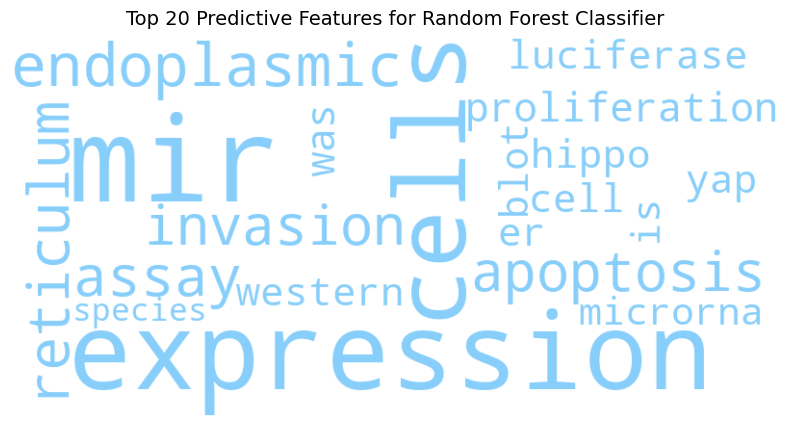

In [135]:

# Select the top words (assuming sorted_coefficients_log_reg is sorted by magnitude)

top_words_rf = top_features_rf[:k_value]

# Separate positive and negative words
positive_words = {word for word, coeff in top_words_rf if coeff > 0}
negative_words = {word for word, coeff in top_words_rf if coeff < 0}

# Generate word cloud with custom color function
def fixed_color_func(word, font_size, position, orientation, random_state=42, **kwargs):
    if word in positive_words:
        return "rgb(135, 206, 250)"  # Light blue for positive coefficients
    elif word in negative_words:
        return "rgb(192, 192, 192)"  # Light grey for negative coefficients
    return "rgb(128, 128, 128)"  # Default grey

# Convert top_words into a dictionary with absolute values for size scaling
word_freq_dict_rf = {word: abs(coeff) for word, coeff in top_words_rf}

# Generate word cloud
wordcloud = WordCloud(
    width=800, height=400, background_color='white', color_func=fixed_color_func
).generate_from_frequencies(word_freq_dict_rf)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Top {k_value} Predictive Features for Random Forest Classifier", fontsize=14)
plt.show()



We can once again inspect manually inspect to see what papers used some of the words that are most predictive of retraction:

In [136]:

# Create filtered data frame with abstracts that include the word "assay" only

df_key_word = df_corpus[df_corpus["abstract_text"].str.contains("expression")]

# Visualize abstracts in filtered data frame

df_key_word["abstract_text"]


0        "Atrial fibrosis occurs frequently with struct...
2        "Biglycan (BGN) is an important component of t...
5        "Cerebellar fastigial nucleus electrical stimu...
6        "Retinoblastoma is an ocular malignancy occurr...
9        "MicroRNA-145 inhibits the activation of the m...
                               ...                        
13051    "Increasing evidence has suggested that microR...
13052    "Globally  the incidence and mortality rates o...
13053    "Background: Apigenin is known to have a broad...
13055    "Severe acute respiratory syndrome coronavirus...
13056    "Pelvic inflammatory disease (PID) is a common...
Name: abstract_text, Length: 6768, dtype: object

And we can zoom in to read a specific abstract as well:

In [137]:

# Visualize abstract of paper with specified index

df_corpus.iloc[2].abstract_text


'"Biglycan (BGN) is an important component of the extracellular matrix (ECM) that is implicated in a variety of human cancers. In our previous study  we reported that BGN was overexpressed in gastric cancer (GC) tissues and promoted cancer metastasis. Moreover  the tubular formation capacity in HUVECs was promoted by stimulation with culture media from BGNoverexpressing GC cells  but the exact underlying mechanism is still unknown. The purpose of this study was to determine the role and molecular mechanism of BGN in VEGF expression in endothelial cells. We found that BGN stimulation of endothelial cells increased the interaction between NFkB and the HIF1 promoter  leading to enhanced promoter activity and increased HIF1 mRNA levels  as well as augmented HIF1 activity that resulted in VEGF expression. All of this was dependent on the interaction of BGN with its receptors  TLR2 and TLR4. Moreover  we found that BGN enhanced endothelial cell migration and proliferation  as well as tube fo

## ROC Curve for all three Models 


- Let us also obtain ROC score and visualize the ROC curve for our regressor:

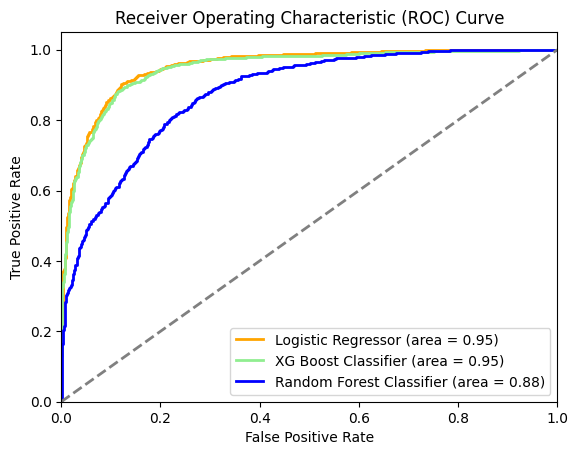

In [138]:

# Obtain predicted probabilities for all three models

y_pred_proba_log_reg = log_reg.predict_proba(X_test_tfidf)[:, 1]
y_pred_proba_xgb = xgboost.predict_proba(X_test_tfidf)[:, 1]
y_pred_proba_rf = rf_classifier.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve for all three models

fpr_log_reg, tpr_log_reg, _log_reg = roc_curve(y_test, y_pred_proba_log_reg)
fpr_xgb, tpr_xgb, _xgb = roc_curve(y_test, y_pred_proba_xgb)
fpr_rf, tpr_rf, _rf = roc_curve(y_test, y_pred_proba_rf)

# Compute area under the curve for all three models

roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_rf = auc(fpr_rf, tpr_rf)


# Plot ROC curve for all three models

plt.figure()

plt.plot(fpr_log_reg, tpr_log_reg, color='orange', lw=2, label='Logistic Regressor (area = %0.2f)' % roc_auc_log_reg)
plt.plot(fpr_xgb, tpr_xgb, color='lightgreen', lw=2, label='XG Boost Classifier (area = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest Classifier (area = %0.2f)' % roc_auc_rf)

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()



## Output

Having evaluated the performance of our models we can proceed to save them, along with the vectorizers that we used to translate our abstracts into numerical data:

In [139]:

# Save logistic regressor

joblib.dump(log_reg, output_path_log_reg)

# Save XGBoost classifier

joblib.dump(xgboost, output_path_xgboost)

# Save random forest classifier

joblib.dump(rf_classifier, output_path_rf)

# Save word count vectorizer

joblib.dump(vectorizer, output_path_vectorizer)

# Save tf-idf vectorizer

joblib.dump(tfidf, output_path_tfidf)


['../data/trained_models/tfidf.pkl']